# An optimized semianalytical way to simulate dephasing

In [2]:
%matplotlib inline

In [3]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
from scipy.constants import *
from scipy.fftpack import ifft, fft
from scipy.integrate import simps
from scipy import exp, linspace, sqrt, array, real, ones_like, imag

In [4]:
import sys
from time import sleep
import pickle
from IPython.display import clear_output

In [5]:
def mul_spectrum(length):
    fs = np.linspace(1, length/2+1, length/2)
    spec_r1 = np.random.uniform(low=-1, size=length/2)*np.sqrt(1/fs)
    spec_r = np.concatenate((spec_r1, np.array([0]), spec_r1[::-1][:-1]))
    spec_i1 = 1j*(np.random.uniform(low=-1, size=length/2))*np.sqrt(1/fs)
    spec_i = np.concatenate((spec_i1, np.array([0]), -spec_i1[::-1][:-1]))
    spec_i[0]=0
    return (spec_i+spec_r)*length/100

In [31]:
font = {'size'   : 20}

matplotlib.rc('font', **font)

Evolution operator ($\hbar = 1$):
$$
\left| \psi(t) \right> = \hat T \exp\left\{ - i \int_0^t f(\tau) \hat \sigma_z d\tau\right\}\left| \psi(0) \right> = 
\left(
\begin{matrix}
\exp\left\{ -i \int_0^t f(\tau) d\tau\right\} & 0 \\
0 & \exp\left\{ i \int_0^t f(\tau) d\tau\right\}
\end{matrix}
\right)
\left(
\begin{matrix}
1/\sqrt{2} \\
1/\sqrt{2}
\end{matrix}
\right) = 
\left(
\begin{matrix}
U(t) & 0 \\
0 & U(t)^{-1}
\end{matrix}
\right)
\left(
\begin{matrix}
1/\sqrt{2} \\
1/\sqrt{2}
\end{matrix}
\right)
$$

Noise function $f(t)$:

/usr/lib64/python3.3/site-packages/numpy/core/numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-0.1, 0.1)

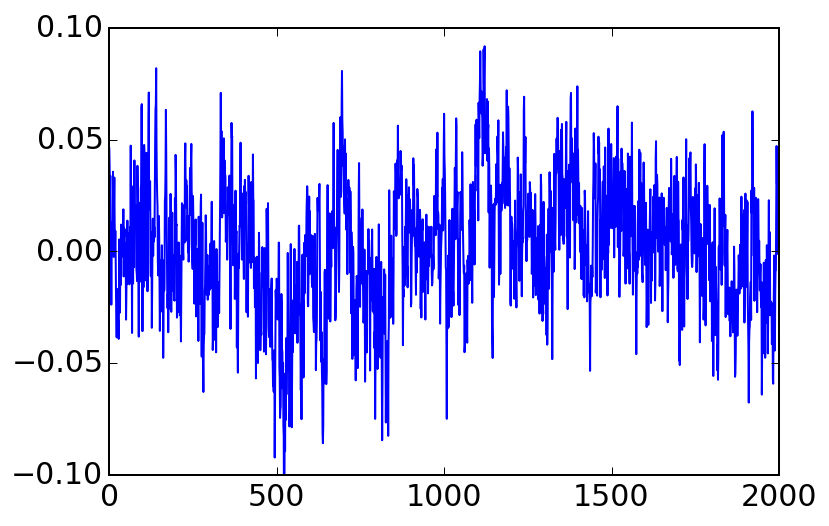

In [7]:
plt.plot(ifft(mul_spectrum(2e3)))
plt.ylim(-0.1, 0.1)

In [8]:
def U(t_start_idx, t_end_idx, noise):
    return exp(-1j*simps(noise,x=Ts[t_start_idx:t_end_idx]))
def U_inv(t_start_idx, t_end_idx, noise):
    return exp(1j*simps(noise, x=Ts[t_start_idx:t_end_idx]))

def sigmazs(states):
    return array([state.conjugate().T.dot(array([[1, 0], [0, -1]])).dot(state) for state in states])
def sigmaxs(states):
    return array([state.conjugate().T.dot(array([[0, 1], [1, 0]])).dot(state) for state in states])
def sigmays(states):
    return array([state.conjugate().T.dot(array([[0, -1j], [1j, 0]])).dot(state) for state in states])

In [14]:
N_avg = 1024
universeTimeStepsPerNs = 16
T_meas = 128

τs = np.arange(0, T_meas, 2)
Ts = np.arange(0, T_meas*N_avg, 1/universeTimeStepsPerNs) # cutoff-defining time grid

In [15]:
def run_simulation(noise_generator, echo):

    states = []
    states.append([1/sqrt(2)*(N_avg-1), 1/sqrt(2)*(N_avg-1)])

    for τ in τs[1:]:
        noise = noise_generator(len(Ts))
        last_t_end_idx = 0

        state = [0,0]

        for i in range(0, N_avg-1):

            t_start_idx = last_t_end_idx
            t_end_idx = np.where(Ts == (Ts[last_t_end_idx]+τ/2))[0][0]

            state_half = [1/sqrt(2)*U(t_start_idx, t_end_idx, noise[t_start_idx:t_end_idx]),
                     1/sqrt(2)*U_inv(t_start_idx, t_end_idx, noise[t_start_idx:t_end_idx])]

            t_start_idx = t_end_idx+1
            t_end_idx = np.where(Ts == (Ts[last_t_end_idx]+τ))[0][0]
            
            if echo:
                state_half = np.conj(state_half)
            state = [state[0]+state_half[0]*U(t_start_idx, t_end_idx, noise[t_start_idx:t_end_idx]),
                             state[0]+state_half[1]*U_inv(t_start_idx, t_end_idx, noise[t_start_idx:t_end_idx])]

            last_t_end_idx = t_end_idx+1


            print("\r τ =", τ, "i =", i, end='')
            sys.stdout.flush()

        states.append(state)
    print(" Done!")
    return array(states)/(N_avg-1)

In [16]:
states_white = run_simulation(lambda len_Ts: np.random.normal(scale=1, size = len_Ts), False)
states_white_se = run_simulation(lambda len_Ts: np.random.normal(scale=1, size = len_Ts), True)
states_pink = run_simulation(lambda len_Ts: real(ifft(mul_spectrum(len_Ts))), False)
states_pink_se = run_simulation(lambda len_Ts: real(ifft(mul_spectrum(len_Ts))), True)

 τ = 126 i = 1022 Done!
 τ = 126 i = 1022 Done!
 τ = 126 i = 1022 Done!
 τ = 126 i = 1022 Done!


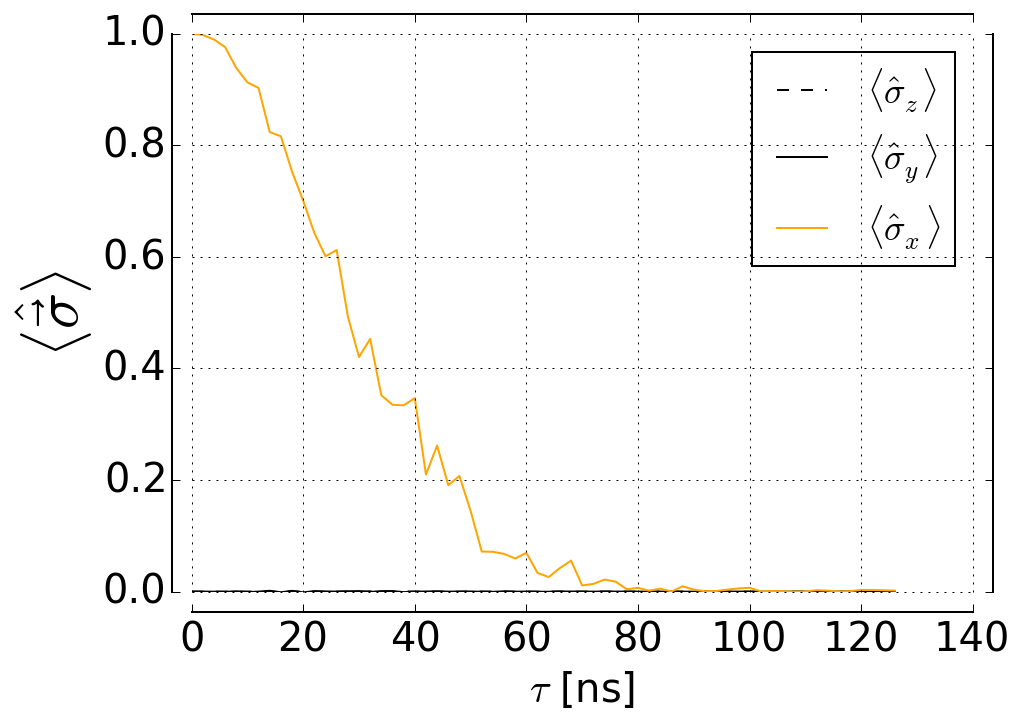

In [51]:
plt.plot(τs, sigmazs(states_pink), "--", color="black", label = "$\\langle \hat \\sigma_z\\rangle$")
plt.plot(τs, sigmays(states_pink), "black", label = "$\\langle \hat\\sigma_y\\rangle$")
plt.plot(τs, sigmaxs(states_pink), "orange", label = "$\\langle\hat\\sigma_x\\rangle$")

dict(plt.gca().spines.items())["left"].set_position(('outward', 10))
dict(plt.gca().spines.items())["bottom"].set_position(('outward', 10))
dict(plt.gca().spines.items())["top"].set_position(('outward', 10))
dict(plt.gca().spines.items())["right"].set_position(('outward', 10))

plt.gcf().set_size_inches(7,5)
plt.grid()
plt.xlabel("$\\tau$ [ns]")
plt.ylabel(r"$\langle\hat\vec\sigma\rangle$", fontsize=30)
plt.legend(loc=1, fontsize=18)
plt.ylim(0,1)
plt.savefig("states_pink.pdf",bbox_inches='tight')

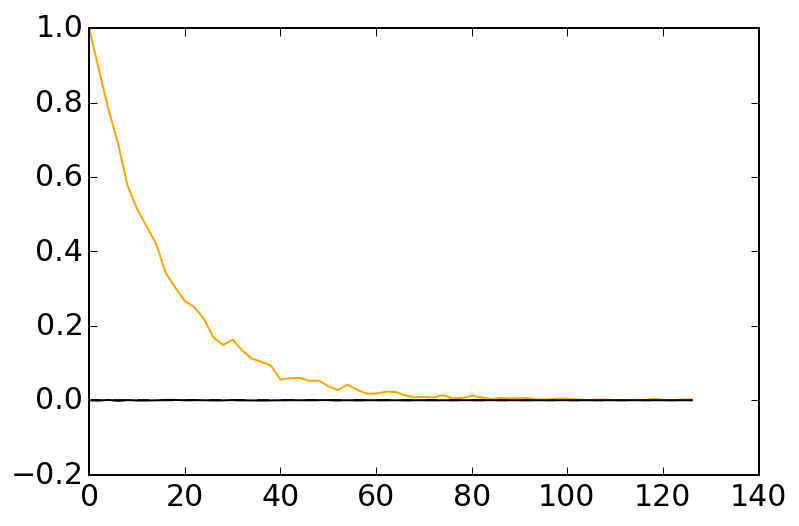

In [20]:
plt.plot(τs, sigmazs(states_white_se), "--", color="black")
plt.plot(τs, sigmaxs(states_white_se), color="orange")
plt.plot(τs, sigmays(states_white_se), color="black")

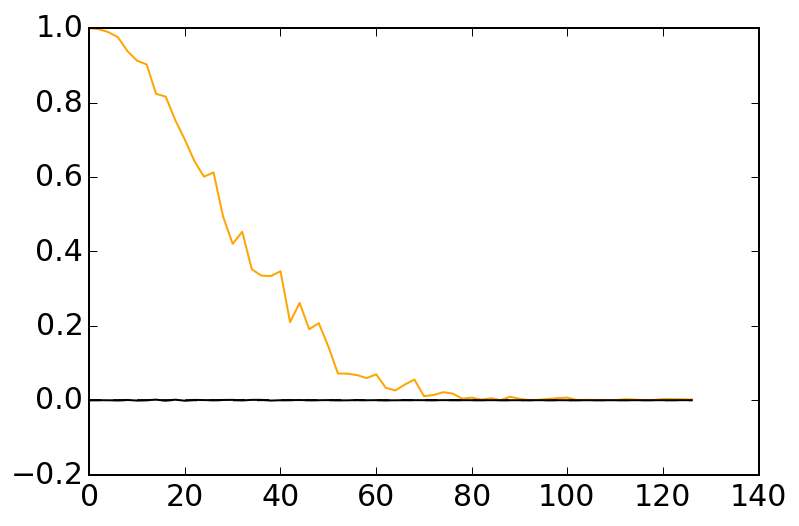

In [21]:
plt.plot(τs, sigmazs(states_pink), "--", color="black")
plt.plot(τs, sigmaxs(states_pink), color="orange")
plt.plot(τs, sigmays(states_pink), color="black")

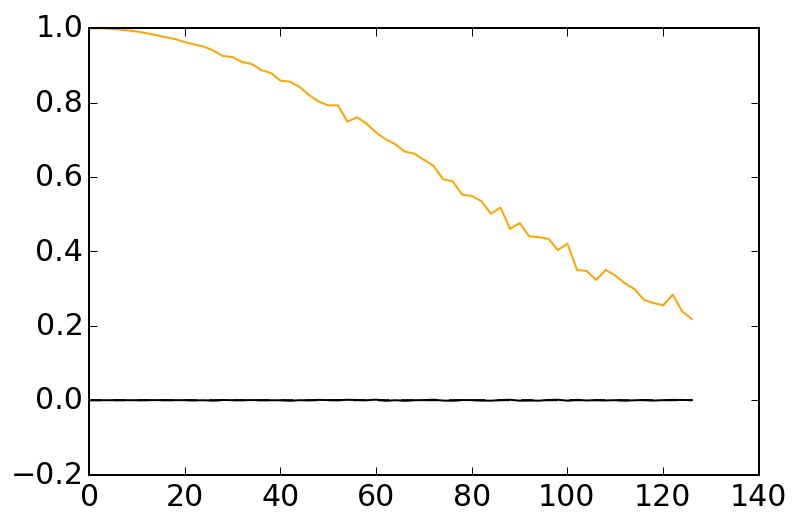

In [22]:
plt.plot(τs, sigmazs(states_pink_se), "--", color="black")
plt.plot(τs, sigmaxs(states_pink_se), color="orange")
plt.plot(τs, sigmays(states_pink_se), color="black")

### Averaging

## Test

In [8]:
a = mul_spectrum(1e6)


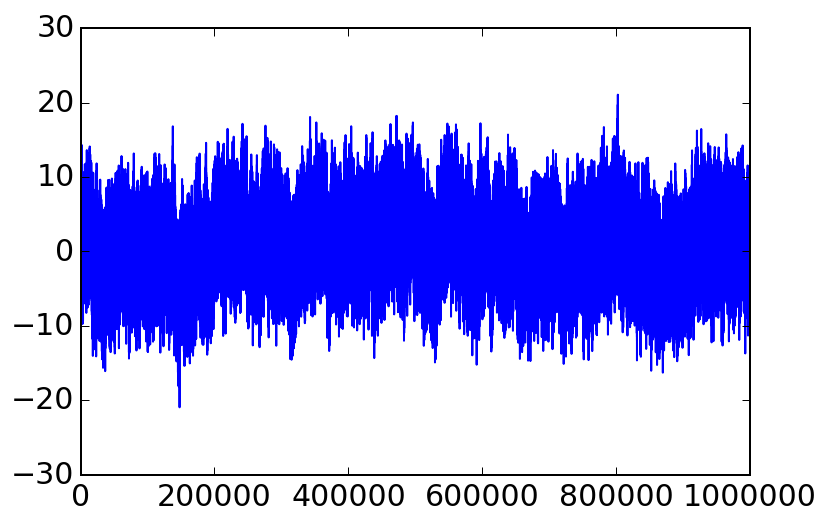

In [9]:
plt.plot(ifft(a))